In [1]:
import os
import sys
from pathlib import Path
sys.path.insert(1, os.path.realpath(os.path.pardir))

import torch
import torch.nn.functional as F
from torch import nn

import safetensors
from accelerate import notebook_launcher

from utils.data_utils import BrainDataset, get_tokenizer
from utils.train_utils import TrainConfig, run_train_model, count_parameters, load_model_weights

from dataclasses import dataclass
from simple_parsing.helpers import Serializable

from safetensors.torch import load_model
import albumentations as A

import matplotlib.pyplot as plt

In [2]:
from models.bert import BrainBert, BertConfig
from models.vq_brain_per_channel import SoundStream, VAEConfig
from models.frankenstein_prefix import PrefixFranky

## Init brain module

In [3]:
vae_config = VAEConfig(C=256, levels=(8, 8, 6, 5))
vq_vae = SoundStream(**vae_config.to_dict())

model_config = BertConfig(dim=256, 
                 window_size=512, 
                 tokenizer_downsample=int(vq_vae.downsample),
                 n_electrodes=256, 
                 mask_ratio=0.0, 
                 n_layers=12, 
                 n_heads=12, 
                 n_kv_heads=12)

bert = BrainBert(model_config, vq_vae)

self.codebook_size 1920
self.downsample 8
BertConfig(window_size=512, n_electrodes=256, mask_ratio=0.0, tokenizer_downsample=8, n_layers=12, dim=256, hidden_dim=1024, head_dim=32, n_heads=12, n_kv_heads=12)
Encoder: number of parameters: 42.79M


## Init language model

In [4]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
gpt2 = GPT2LMHeadModel.from_pretrained('gpt2-medium')
gpt2.train()

/opt/conda/envs/pytorch/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

## Init Franky

In [5]:
@dataclass
class CombinerConfig(Serializable):
    # data params
    n_registers: int = 2
    n_layers: int = 6
    dim: int = 256
    hidden_dim: int = 1024

    head_dim: int = 32
    n_heads: int = 8
    n_kv_heads: int = 8

@dataclass
class CausalModelConfig(Serializable):

    block_size: int = 0
    rope_theta: float = 10000.0

    # data params
    n_layers: int = 6
    dim: int = 256
    hidden_dim: int = 1024
    dropout: float = 0.0
    
    head_dim: int = 32
    n_heads: int = 8
    n_kv_heads: int = 8
    calculate_loss: bool = False

In [6]:
combiner_config = CombinerConfig()
causal_config = CausalModelConfig()

model = PrefixFranky(combiner_config, causal_config, bert, gpt2, tokenizer)

weights = "/drive/logs/kovalev/frankenstein/prefix-franky-3-bert-gpt2-medium-stage-1/step_8500_loss_5.3446.safetensors"

model = load_model_weights(model, weights)

# bert_weights = "/drive/logs/kovalev/bert/new_vqvae_8x_2000_large_bert_30M_0_25/step_6500_loss_1.4677.safetensors"
# model.brain_model = load_model_weights(model.brain_model, bert_weights)

# let's freeeze weights 
for param in model.brain_model.parameters():
    param.requires_grad = False

for param in model.llm_model.parameters():
    param.requires_grad = True

# for np, p in model.llm_model.transformer.named_parameters():
#     if "cross" in np:
#         p.requires_grad = True

for param in model.llm_model.transformer.wte.parameters():
    param.requires_grad = False
    
for param in model.llm_model.transformer.wpe.parameters():
    param.requires_grad = False

for param in model.llm_model.lm_head.parameters():
    param.requires_grad = False

count_parameters(model)
count_parameters(model.llm_model)

Full Franky: number of parameters: 397.90M
load default weights
Total: 397.90M, Trainable: 302.60M
Total: 354.82M, Trainable: 302.31M


(354823168, 302311424)

In [7]:
# count_parameters(model)

In [8]:
window_size = model_config.window_size
n_electrodes = 256

train_transform = A.Compose([
    
    # A.CoarseDropout(fill_value=0, p=0.5),
    # A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),
    A.GaussNoise(var_limit=0.005, mean=0, p=0.5),

    A.PadIfNeeded(min_height=window_size, min_width=n_electrodes, position='random', 
                  border_mode=0, value=0, always_apply=True),
    # A.RandomCrop(height=window_size, width=n_electrodes, always_apply=True),
    A.Crop(x_min=0, x_max=n_electrodes, y_min=0, y_max=window_size, always_apply=True),

])

test_transform = A.Compose([
    A.PadIfNeeded(min_height=window_size, min_width=n_electrodes, position='top_left', 
                  border_mode=0, value=0, always_apply=True),
    A.Crop(x_min=0, x_max=n_electrodes, y_min=0, y_max=window_size, always_apply=True)
])


data_path = Path("/drive/data/competitionData")

train_dataset = BrainDataset(data_path / 'train', tokenize_function=get_tokenizer(tokenizer), transform=train_transform)
test_dataset = BrainDataset(data_path / 'test', tokenize_function=get_tokenizer(tokenizer), transform=test_transform)

Runed processing of the  /drive/data/competitionData/train
len of the dataset: 8800
max input len 906
median len 297.0
Runed processing of the  /drive/data/competitionData/test
len of the dataset: 880
max input len 919
median len 283.5


In [9]:
# for idx in [0,100, 200, 300, 400, 500, 600]:
#     sample = train_dataset[idx]
#     x, y = sample[0], sample[1]
#     print(y)
#     plt.imshow(x.T)
#     plt.show()
    

torch.Size([1, 512, 256]) torch.Size([1, 25]) tensor([0])


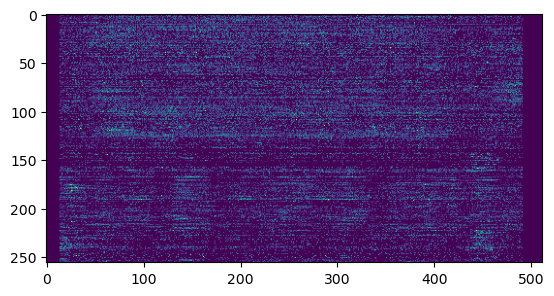

In [10]:
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

x, y, date = next(iter(train_dataloader))
loss, logits = model(x, y, date)

print(x.shape, y.shape, date)
plt.imshow(x.detach()[0].T)
plt.show()

# Work with data

In [ ]:
project_name = 'frankenstein'
save_folder = Path("/drive/logs/kovalev")

train_config = TrainConfig(exp_name='prefix-franky-3-bert-gpt2-medium-stage-2-pretrained',
                           mixed_precision=True,
                           batch_size=16, 
                           grad_accum=1,
                           num_workers=3,
                           pin_memory=True, 
                           eval_interval=250, 
                           learning_rate=1e-4,
                           weight_decay=0.01, 
                           grad_clip=5,
                           lr_decay_iters=20_000, 
                           warmup_iters=1000, 
                           project_name=project_name, 
                           save_folder=save_folder
                          )


args = (model, (train_dataset, test_dataset), train_config, model_config)
notebook_launcher(run_train_model, args, num_processes=1)

Launching training on one GPU.


/opt/conda/envs/pytorch/lib/python3.10/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=True)
  warnings.warn(
wandb: Currently logged in as: koval_alvi. Use `wandb login --relogin` to force relogin


Device for training:  cuda
Num devices:  1
Completed initialization of scheduler
**********************************************************************************************************************************************************************************************************************************************************
overall_steps 250: 4.564154148101807
val loss: 5.106922149658203
saved model:  step_250_loss_5.1069.safetensors
**********************************************************************************************************************************************************************************************************************************************************
overall_steps 500: 4.575767517089844
val loss: 4.782719135284424
saved model:  step_500_loss_4.7827.safetensors
*************************************************************************************************************************************************************************************************

In [ ]:
save_folder = Path("/drive/logs/kovalev")

safetensors.torch.save_model(model, save_folder / 'model_mae_long_train.safetensors')

In [ ]:
model

In [ ]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [ ]:
model = model._orig_mod

In [ ]:
mae_weights = "/drive/logs/kovalev/fixed_abs_mae_11M_5M_spikes/step_34000_loss_0.0166.safetensors"

mae_model = SimpleMAE( SimpleEncoderConfig(), SimpleMAEConfig())
mae_model = torch.compile(mae_model)
safetensors.torch.load_model(mae_model, mae_weights)
mae_model = mae_model._orig_mod

brain_model = mae_model.encoder

In [ ]:
x = test_dataset[0][0]
device = 'cpu'
x = torch.from_numpy(x[None, :]).to(device)
print(x.shape)
loss, y, binary = model(x, masking_ratio=0.75,  return_preds=True)

x = x.detach().cpu()[0]
y = y.detach().cpu()[0]
binary = binary.detach().cpu()[0]

import matplotlib.pyplot as plt 

# plt.plot(y[1, :])
# plt.show()
# plt.plot(x[1, :])
# plt.show()
loss = F.l1_loss(y, x, reduction='none')
print(torch.mean(loss[loss>0]))

plt.show()
plt.imshow(binary[:64].T, aspect='auto')
# plt.colorbar()
plt.show()
plt.imshow(torch.clip(y[:64].T, 0, 1), aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(x[:64].T, aspect='auto' )
plt.colorbar()


In [ ]:
plt.show()
plt.plot(binary[:32, 10])
plt.show()
plt.plot(y[:32, 10])
# plt.show()
plt.plot(x[:32, 10])